<a href="https://colab.research.google.com/github/Sean-Wu-TW/257-Group-Project/blob/main/Yathukulan/Resnet34_facemask_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/CMPE257projectdata"

/content/drive/MyDrive/CMPE257projectdata


In [3]:
ls

maskdata/  masks2.0/  savedmodel


In [4]:
import os
import pandas as pd
import numpy as np
from fastai.callbacks.hooks import *

import cv2
import torch

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [6]:
from fastai import *
from fastai.vision import *

#### check if CUDA is avaialble

In [7]:
torch.__version__

'1.7.0+cu101'

In [8]:
torch.version.cuda

'10.1'

In [9]:
#if using google colab: set runtime to GPU
torch.cuda.is_available()

True

In [10]:
!nvidia-smi

Thu Dec 17 04:59:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     7W /  75W |     10MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Load the data as an Image data bunch

In [11]:
path = Path('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata')
path.ls()

[PosixPath('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/borderline_cases'),
 PosixPath('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/validation'),
 PosixPath('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/training'),
 PosixPath('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/test')]

In [12]:
CONST_IMG_DIMENSION =224 #=224 = 32 * 7 

#we need 244 x 244 img for the given kernel size of 7x7 of resnet34 
#why? https://www.sicara.ai/blog/2019-10-31-convolutional-layer-convolution-kernel , 
#https://github.com/albanie/convnet-burden/blob/master/reports/resnet34.md#:~:text=Report%20for%20resnet34&text=Estimates%20for%20a%20single%20full,required%20for%20features%3A%2035%20MB
#https://cv-tricks.com/keras/understand-implement-resnets/

#try without resize squish?
data = (ImageList.from_folder(path)
       .split_by_folder(train='training',valid='validation')
       .label_from_folder()
       .transform(get_transforms(),size=CONST_IMG_DIMENSION,resize_method=ResizeMethod.SQUISH)
       .databunch(bs=25))
data

ImageDataBunch;

Train: LabelList (616 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
without_mask,without_mask,without_mask,without_mask,without_mask
Path: /content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata;

Valid: LabelList (198 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
with_mask,with_mask,with_mask,with_mask,with_mask
Path: /content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata;

Test: None

In [13]:
#check classes
data.classes

['with_mask', 'without_mask']

In [14]:
# data.show_batch() # sample batch

#### Train Data

In [15]:
resnet34_learn = cnn_learner(data,models.resnet34,metrics=[accuracy])
vgg19_bn_learn = cnn_learner(data,models.vgg19_bn,metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


In [16]:
resnet34_learn.fit_one_cycle(cyc_len=4)
# more on the one cycle policy https://iconof.com/1cycle-learning-rate-policy/  https://arxiv.org/abs/1708.07120

In [17]:
# vgg19_bn_learn.fit_one_cycle(cyc_len=4)

#### classification statistics

In [18]:
def learnerinfo(learnobj):
  learnobj.recorder.plot_metrics()
  learnobj.recorder.plot_losses()
  learnobj.recorder.plot_lr()
  learnobj.recorder.plot()
  learnobj.summary()

In [19]:
def show_stats_classif(learnobj):
  classif_int = ClassificationInterpretation.from_learner(learnobj)
  classif_int.plot_confusion_matrix(figsize=(8,8))

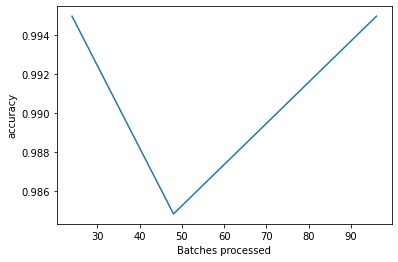

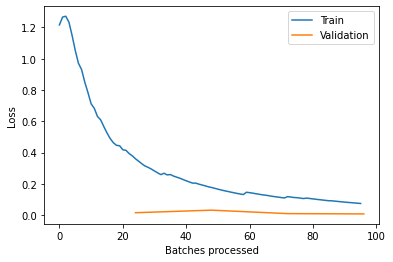

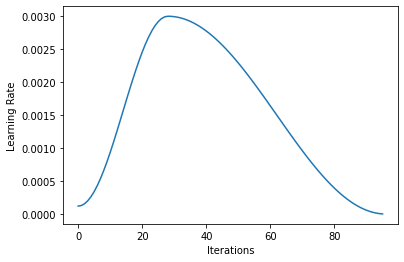

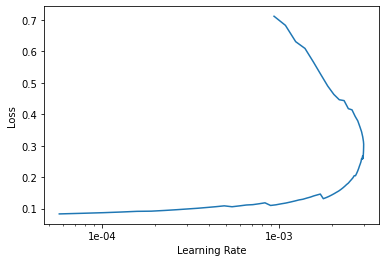

In [20]:
learnerinfo(resnet34_learn)

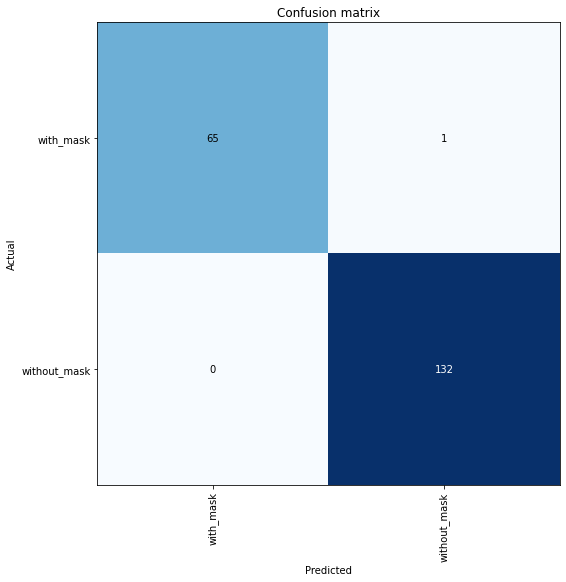

In [21]:
show_stats_classif(resnet34_learn)

In [22]:
model_resnet34=resnet34_learn.model.eval()

## plot important features in an image according to activations and gradients

In [23]:
#find hooks with backpropagation
#more on hooks: https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html

def find_backward_hooks(img_tensor, classification, model):
    with hook_output(model[0]) as hook_acts: #returns activations
        with hook_output(model[0], grad=True) as hook_grads: #returns gradients
            preds = model(img_tensor)
            preds[0,int(classification)].backward() #backprop
    return hook_acts,hook_grads

In [24]:
#plot a heatmap of features
def plot_heatmap(tensor_inp, image, title):
    _,ax = plt.subplots()
    image.show(ax)
    ax.imshow(tensor_inp, alpha=0.6, extent=(0,CONST_IMG_DIMENSION,CONST_IMG_DIMENSION,0),
              interpolation='bilinear', cmap='seismic');
    plt.title(title)

In [25]:
#find important features and overlay them on the image
def find_feature_importance(img, classification, model):
  

  img_tensor,_ = data.one_item(img)
  image = Image(img_tensor.view(3,CONST_IMG_DIMENSION,CONST_IMG_DIMENSION))

  img_tensor = img_tensor.cuda() # .cuda() transfers a tensor from CPU to GPU 

  hook_acts,hook_grads = find_backward_hooks(img_tensor=img_tensor, classification=classification, model=model)

  acts  = hook_acts.stored[0].cpu() # .cpu() transfers a tensor from GPU to CPU 
  acts_avg = acts.mean(0) #find the mean of activations per each lcoation

  grads = hook_grads.stored[0].cpu()

  grads = grads[0]
  grads_avg = grads.mean(0)

  plot_heatmap(acts_avg, image,'heatmap of activations')

  plot_heatmap(grads_avg, image, 'heatmap of gradients')


In [26]:
# find_feature_importance(img, classification,model_resnet34)

In [27]:
model_resnet34.model_dir ='/content/drive/MyDrive/CMPE257projectdata/model/resnet34' #save model parameters to this dir

#### Classify unseen input

In [28]:
def challenge (inp_path, model, learnerobj):
  challenge_img = open_image(inp_path)
  

  classification, *_= learnerobj.predict(challenge_img)
  #print(classification)
  challenge_img.show(title=str(classification),figsize=(4,4))
  find_feature_importance(challenge_img, classification, model)

In [29]:
resnet34_learn.export(Path('/content/drive/MyDrive/CMPE257projectdata/savedmodel')) #save the model

In [30]:
# challenge_data = (ImageList.from_folder(challenge_path)
#        .split_by_folder(train='challenge')
#        .label_from_folder()
#       # .transform(get_transforms(),size=CONST_IMG_DIMENSION,resize_method=ResizeMethod.SQUISH)
#        .databunch(bs=10))

# challenge_data

In [31]:
# challenge_data.classes

In [32]:
#resnet34_learn.show_results(challenge_data,shuffle=True)

In [33]:
# predictions, *_ = resnet34_learn.predict(challenge_data)
# predictions

## Verify training data

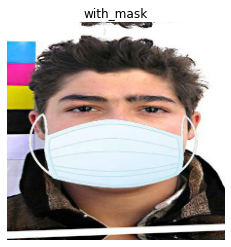

In [34]:
#verify training data

picnum=300
img, classification = data.train_ds[picnum]
img.show(title=str(classification),figsize=(4,4))
#data.valid_ds.y[picnum]

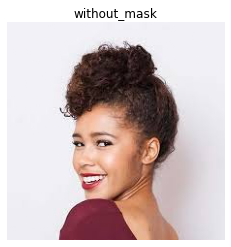

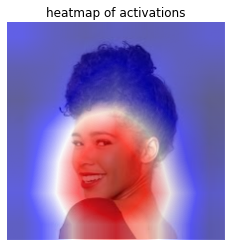

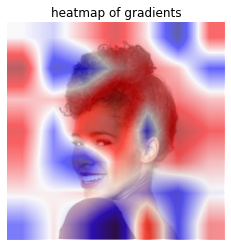

In [35]:
#verify heatmap
path = '/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/training/without_mask/211.jpg'
challenge(path, model_resnet34, resnet34_learn)

## Predict on unseen test data (challenge with 125 images)

In [36]:
def give_preds_list (path, learnerobj, expected):
  preds = []
  failiure_imgs =[]

  for subdir, _, files in os.walk(path):
    for filename in files:
      img_path = os.path.join(subdir, filename)
      challenge_img = open_image(img_path)
      classification, *_= resnet34_learn.predict(challenge_img)
      preds.append(str(classification))

      if (str(classification) != expected):
        failiure_imgs.append(img_path)

  return preds, failiure_imgs

In [37]:
def plot_failiures (img, model, learnerobj):
  img.show(figsize=(10,10))

  find_feature_importance(img, classification, model)

In [38]:
def plot_acts_failiures(img, classification, model):

    img_tensor,_ = data.one_item(img)
    image = Image(img_tensor.view(3,CONST_IMG_DIMENSION,CONST_IMG_DIMENSION))

    img_tensor = img_tensor.cuda() # .cuda() transfers a tensor from CPU to GPU 

    hook_acts,hook_grads = find_backward_hooks(img_tensor=img_tensor, classification=classification, model=model)

    acts  = hook_acts.stored[0].cpu() # .cpu() transfers a tensor from GPU to CPU 
    acts_avg = acts.mean(0) #find the mean of activations per each lcoation

    plot_heatmap(acts_avg, image,'heatmap of activations')

In [39]:
def plot_fails (inp_paths, model, learnerobj):

  for inp_path in inp_paths:
    challenge_img = open_image(inp_path)
    classification, *_= learnerobj.predict(challenge_img)
    plot_acts_failiures(challenge_img, classification, model)

In [79]:
challenge_path_mask = Path('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/test/with_mask') #74 items
challenge_path_no_mask = Path('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/test/without_mask') #51 items

training_path_mask = Path('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/training/with_mask') #341 items
training_path_no_mask = Path('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/training/without_mask') #275 items

validation_path_mask = Path('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/validation/with_mask') #66 items
validation_path_no_mask = Path('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/validation/without_mask') #132 items

In [80]:
%%time 
#get predictions for the heatmap
preds_mask, failiures_mask = give_preds_list(challenge_path_mask,resnet34_learn,'with_mask')
preds_no_mask, failiures_no_mask = give_preds_list(challenge_path_no_mask,resnet34_learn,'without_mask')

CPU times: user 3.28 s, sys: 183 ms, total: 3.47 s
Wall time: 3.59 s


In [81]:
%%time 
#get predictions for the heatmap
training_preds_mask, training_failiures_mask = give_preds_list(training_path_mask,resnet34_learn,'with_mask')
training_preds_no_mask, training_failiures_no_mask = give_preds_list(training_path_no_mask,resnet34_learn,'without_mask')

CPU times: user 9.19 s, sys: 430 ms, total: 9.62 s
Wall time: 10.2 s


In [82]:
%%time 
#get predictions for the heatmap
validation_preds_mask, validation_failiures_mask = give_preds_list(validation_path_mask,resnet34_learn,'with_mask')
validation_preds_no_mask, validation_failiures_no_mask = give_preds_list(validation_path_no_mask,resnet34_learn,'without_mask')

CPU times: user 2.97 s, sys: 153 ms, total: 3.12 s
Wall time: 3.3 s


In [43]:
# preds_no_mask

In [44]:
# failiures_mask

### plot misclassifications for with mask (if any)

In [45]:
len(failiures_mask)

4

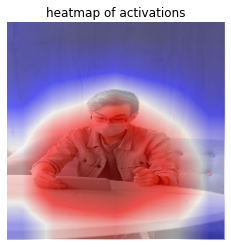

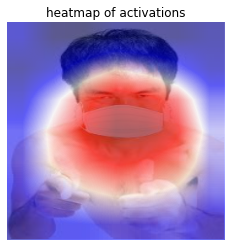

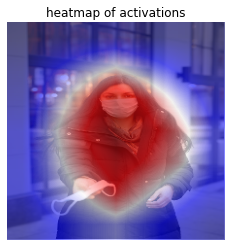

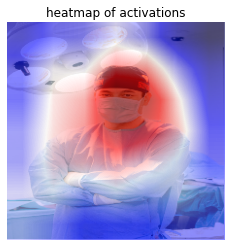

In [46]:
plot_fails(failiures_mask,model_resnet34, resnet34_learn)

### plot misclassifications for without mask (if any)

In [47]:
len(failiures_no_mask)

0

In [48]:
plot_fails(failiures_no_mask,model_resnet34, resnet34_learn)

## Therefore, this achieves the goal of No False positives for the given test data

In [49]:
# labels = np.argmax(predictions, 1)
# labels

### plot the confusion matrix of the test data

In [50]:
len(preds_mask)

74

In [52]:
len(gnd_truth)

125

In [96]:
x = np.array([[ 0,  1,  2],
              [ 3,  4,  5],
              [ 6,  7,  8],
              [ 9, 10, 11]])

In [99]:
x[2,1]

7

In [101]:
def find_acc_and_f1(cnf_mat):

  tp = cnf_mat[0,0]
  tn = cnf_mat[1,1]

  fp = cnf_mat[1,0]
  fn = cnf_mat[0,1]

  precision = tp / (tp+fp)
  recall = tp/ (tp+fn)

  acc = (tn+tp)/(tn+fp+tp+fn)
  f1 = (2* (precision*recall)) /(precision+recall)

  return acc, f1

In [104]:
def plot_confusion_mat(preds_mask,preds_no_mask,plot_title):
  #set up lists of truths and predictions
  true_mask = ['with_mask'] * len(preds_mask)
  true_no_mask = ['without_mask'] * len(preds_no_mask)

  challenge_preds = preds_mask + preds_no_mask
  gnd_truth = true_mask + true_no_mask

  cnf_mat = confusion_matrix(gnd_truth, challenge_preds)

  acc, f1 = find_acc_and_f1(cnf_mat)
  print('accuracy score = ',acc,'\nf1 score =',f1)

  cnf_df = pd.DataFrame(cnf_mat, columns=np.unique(gnd_truth), index = np.unique(gnd_truth))
  cnf_df.index.name = 'Actual'
  cnf_df.columns.name = 'Predicted'
  plt.figure(figsize=(6,6))
  plt.title(plot_title,size=20)
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(cnf_df, cmap="Blues", annot=True,cbar=False,annot_kws={"size": 35})

accuracy score =  0.968 
f1 score = 0.9722222222222222


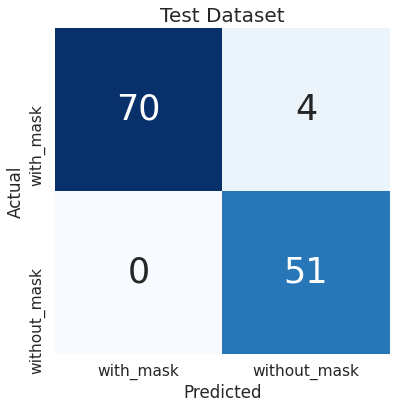

In [105]:
plot_confusion_mat(preds_mask=preds_mask,preds_no_mask=preds_no_mask,plot_title='Test Dataset')

accuracy score =  0.9967532467532467 
f1 score = 0.9970588235294118


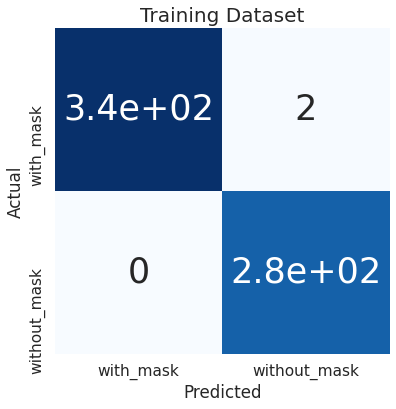

In [106]:
plot_confusion_mat(preds_mask=training_preds_mask,preds_no_mask=training_preds_no_mask,plot_title='Training Dataset')

accuracy score =  0.9949494949494949 
f1 score = 0.9923664122137404


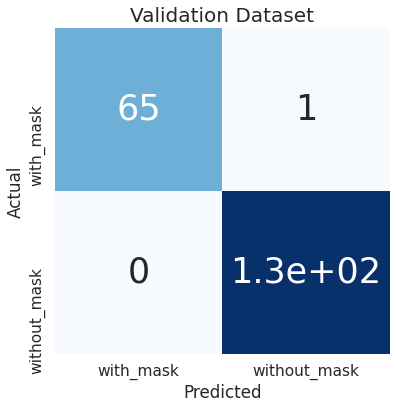

In [107]:
plot_confusion_mat(preds_mask=validation_preds_mask,preds_no_mask=validation_preds_no_mask,plot_title='Validation Dataset')

### Example from the test dataset and heatmaps of their respective average activations and average gradient changes during backpropgation

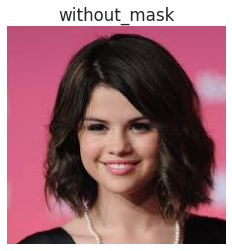

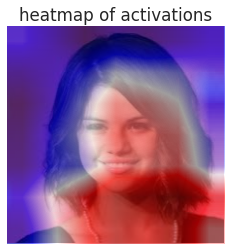

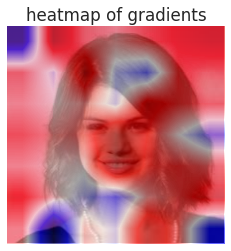

In [55]:
path = '/content/drive/MyDrive/CMPE257projectdata/masks2.0/masks/test/0/11.jpg'
challenge(path, model_resnet34, resnet34_learn)

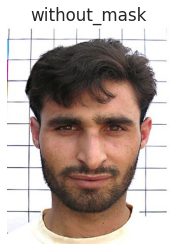

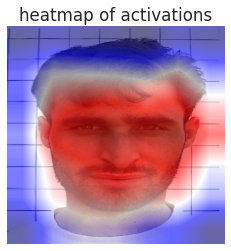

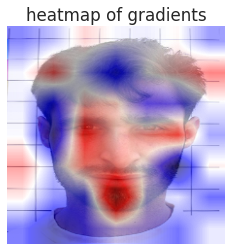

In [56]:
path = '/content/drive/MyDrive/CMPE257projectdata/masks2.0/masks/train/0/59.jpg'
challenge(path, model_resnet34, resnet34_learn)

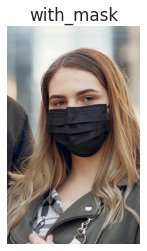

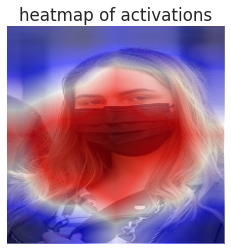

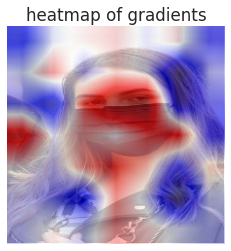

In [57]:
path = '/content/drive/MyDrive/CMPE257projectdata/masks2.0/masks/test/1/7 w.jpeg'
challenge(path, model_resnet34, resnet34_learn)

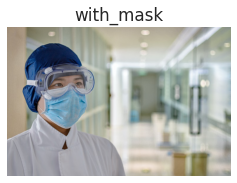

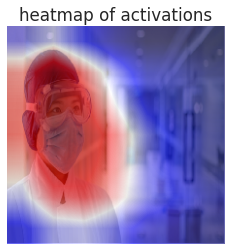

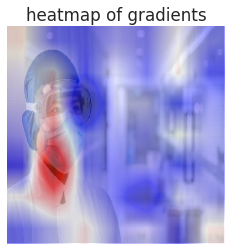

In [58]:
path = '/content/drive/MyDrive/CMPE257projectdata/masks2.0/masks/train/1/16.jpg'
challenge(path, model_resnet34, resnet34_learn)

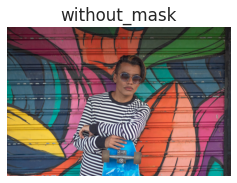

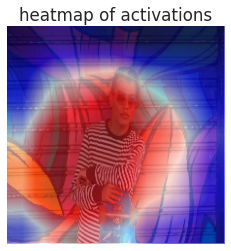

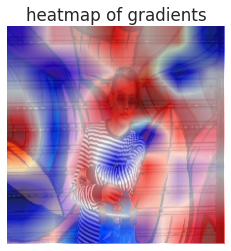

In [59]:
path = '/content/drive/MyDrive/CMPE257projectdata/masks2.0/masks/train/0/pexels-photo-4048805.jpeg'
challenge(path, model_resnet34, resnet34_learn)

## Other examples (Borderline / Adversarial cases as suggested by the professor during the presentation)

### Animals

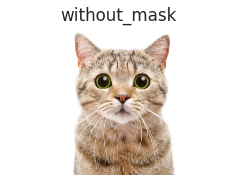

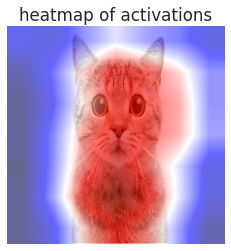

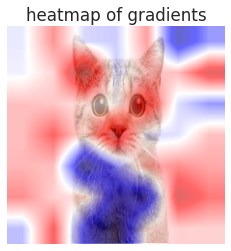

In [60]:
path = '/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/borderline_cases/cat.jpg'
challenge(path, model_resnet34, resnet34_learn)

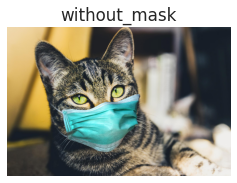

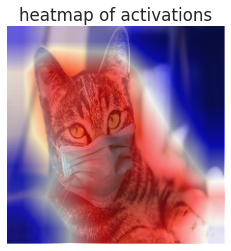

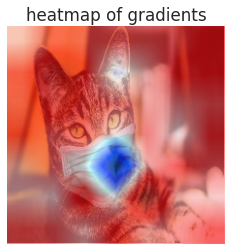

In [61]:
path = '/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/borderline_cases/masked_cat.jpg'
challenge(path, model_resnet34, resnet34_learn)

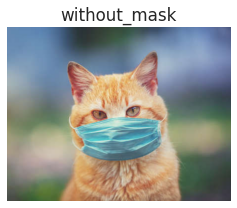

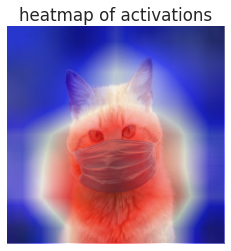

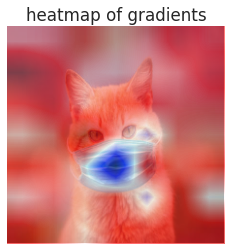

In [62]:
path = '/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/borderline_cases/masked_cat_2.jpg'
challenge(path, model_resnet34, resnet34_learn)

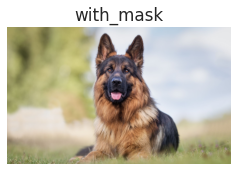

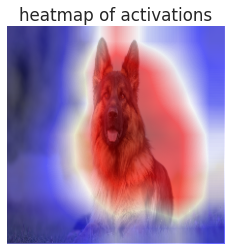

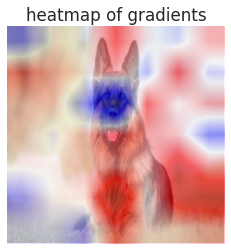

In [63]:
#note that the different colored snout of the german shepard could be mistaken for a mask.
path = '/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/borderline_cases/dog.jpg'
challenge(path, model_resnet34, resnet34_learn)

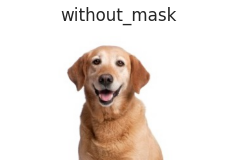

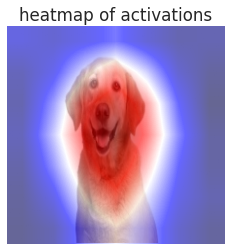

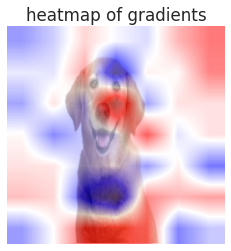

In [64]:
path = '/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/borderline_cases/dog_2.jpg'
challenge(path, model_resnet34, resnet34_learn)

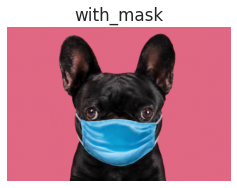

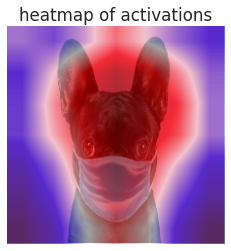

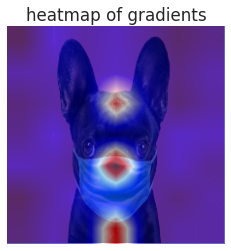

In [65]:
path = '/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/borderline_cases/masked_dog.jpg'
challenge(path, model_resnet34, resnet34_learn)

### just masks. no wearer

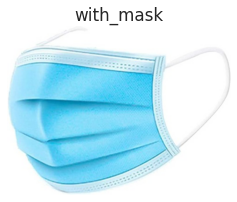

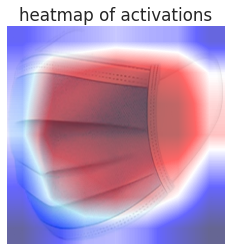

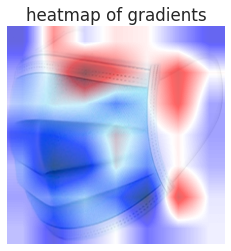

In [66]:
path = '/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/borderline_cases/only_mask_blue.jpg'
challenge(path, model_resnet34, resnet34_learn)

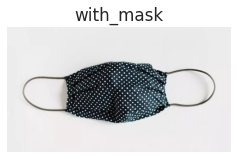

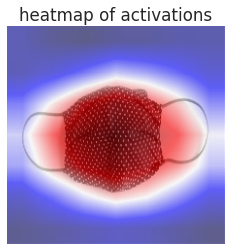

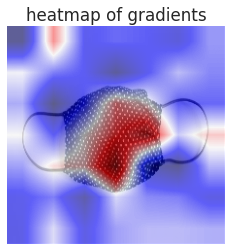

In [67]:
path = '/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/borderline_cases/only_mask_black_with_dots.jpg'
challenge(path, model_resnet34, resnet34_learn)

### Fictional characters / costumed characters

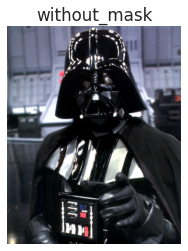

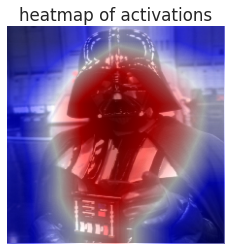

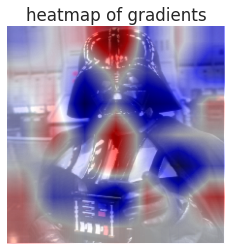

In [68]:
path = '/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/borderline_cases/darth_vader.jpg'
challenge(path, model_resnet34, resnet34_learn)

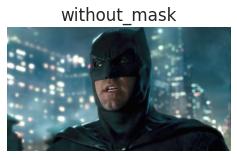

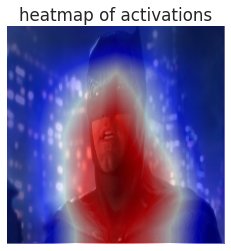

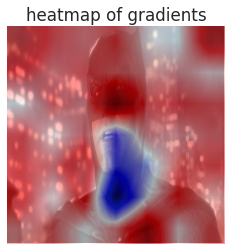

In [69]:
path = '/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/borderline_cases/batman.jpeg'
challenge(path, model_resnet34, resnet34_learn)

### transparent masks

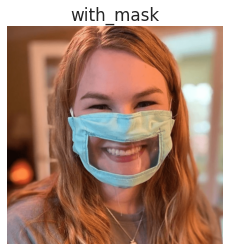

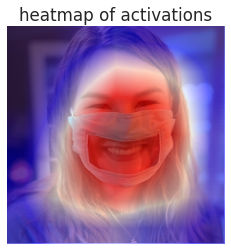

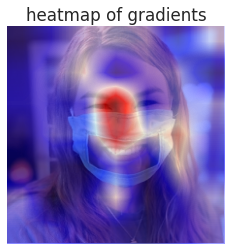

In [70]:
path = '/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/borderline_cases/transparent_mask.png'
challenge(path, model_resnet34, resnet34_learn)

In [71]:
model_resnet34.parameters

<bound method Module.parameters of Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine